In this notebook/pdf we will be discussing how to implement decision trees and random forest models in python . For theoretical discussion, please refer to theoretical discussion reading material.

We'll be solving the revenue grid case study , this time using decision trees and random forests. Lets start with importing the data and required packages which we are going to use for decision trees

In [1]:
data_file=r'/Users/lalitsachan/Dropbox/March onwards/Python Data Science/Data/Existing Base.csv'

import pandas as pd
import math
from sklearn.cross_validation import train_test_split
from sklearn import tree
import numpy as np
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

%matplotlib inline

bd=pd.read_csv(data_file)

We'll be using same set of data, lets reuse the data prep steps used earlier . 

In [2]:
# data prep from previous module
bd.loc[bd["children"]=="Zero","children"]="0"
bd.loc[bd["children"]=="4+","children"]="4"
bd["children"]=pd.to_numeric(bd["children"],errors="coerce")
bd["y"]=1
bd.loc[bd["Revenue Grid"]==2,"y"]=0
bd=bd.drop(["Revenue Grid"],1)
for i in range(len(bd)):
    if bd["age_band"][i] in ["71+","65-70","51-55","45-50"]:
        bd.loc[i,"age_band"]="ab_10"
    if bd["age_band"][i] in ["55-60","41-45","31-35","22-25","26-30"]:
        bd.loc[i,"age_band"]="ab_11"
    if bd["age_band"][i]=="36-40":
        bd.loc[i,"age_band"]="ab_13"
    if bd["age_band"][i]=="18-21":
        bd.loc[i,"age_band"]="ab_17"
    if bd["age_band"][i]=="61-65":
        bd.loc[i,"age_band"]="ab_9"
ab_dummies=pd.get_dummies(bd["age_band"])
bd=pd.concat([bd,ab_dummies],1)
bd=bd.drop(["age_band","Unknown"],1)
bd["st_partner"]=0
bd["st_singleNm"]=0
bd["st_divSep"]=0
bd.loc[bd["status"]=="Partner","st_partner"]=1
bd.loc[bd["status"]=="Single/Never Married","st_singleNm"]=1
bd.loc[bd["status"]=="Divorced/Separated","st_divSep"]=1
bd=bd.drop(["status"],1)
for i in range(len(bd)):
    if bd["occupation"][i] in ["Unknown","Student","Secretarial/Admin",
                               "Other","Manual Worker"]:
        bd.loc[i,"occupation"]="oc_11"
    if bd["occupation"][i] in ["Professional","Business Manager"]:
        bd.loc[i,"occupation"]="oc_12"
    if bd["occupation"][i]=="Retired":
        bd.loc[i,"occupation"]="oc_10"
oc_dummies=pd.get_dummies(bd["occupation"])
bd=pd.concat([bd,oc_dummies],1)

bd=bd.drop(["occupation","Housewife"],1)
bd["ocp_10"]=0
bd["ocp_12"]=0

for i in range(len(bd)):
    if bd["occupation_partner"][i] in ["Unknown","Retired","Other"]:
        bd.loc[i,"ocp_10"]=1
    if bd["occupation_partner"][i] in ["Student","Secretarial/Admin"]:
        bd.loc[i,"ocp_12"]=1
bd=bd.drop(["occupation_partner","TVarea","post_code","post_area","region"],1)
bd["hs_own"]=0
bd.loc[bd["home_status"]=="Own Home","hs_own"]=1
del bd["home_status"]
bd["gender_f"]=0
bd.loc[bd["gender"]=="Female","gender_f"]=1
del bd["gender"]
bd["semp_yes"]=0
bd.loc[bd["self_employed"]=="Yes","semp_yes"]=1
del bd["self_employed"]
bd["semp_part_yes"]=0
bd.loc[bd["self_employed_partner"]=="Yes","semp_part_yes"]=1
del bd["self_employed_partner"]
bd["fi"]=4
bd.loc[bd["family_income"]=="< 8,000, >= 4,000","fi"]=6
bd.loc[bd["family_income"]=="<10,000, >= 8,000","fi"]=9
bd.loc[bd["family_income"]=="<12,500, >=10,000","fi"]=11.25
bd.loc[bd["family_income"]=="<15,000, >=12,500","fi"]=13.75
bd.loc[bd["family_income"]=="<17,500, >=15,000","fi"]=16.25
bd.loc[bd["family_income"]=="<20,000, >=17,500","fi"]=18.75
bd.loc[bd["family_income"]=="<22,500, >=20,000","fi"]=21.25
bd.loc[bd["family_income"]=="<25,000, >=22,500","fi"]=23.75
bd.loc[bd["family_income"]=="<27,500, >=25,000","fi"]=26.25
bd.loc[bd["family_income"]=="<30,000, >=27,500","fi"]=28.75
bd.loc[bd["family_income"]==">=35,000","fi"]=35
bd=bd.drop(["family_income"],1)

We'll remove the missing values first and divide our data into two parts before starting with building the model.

In [3]:
bd.dropna(axis=0,inplace=True)
bd_train, bd_test = train_test_split(bd, test_size = 0.2,random_state=2)
x_train=bd_train.drop(["y","REF_NO"],1)
y_train=bd_train["y"]
x_test=bd_test.drop(["y","REF_NO"],1)
y_test=bd_test["y"]
x_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [4]:
# creating a decision tree class object
dtree=tree.DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=10,
                                  class_weight="balanced")

Lets discuss the parameters involved here . If you look at the documentation, you'll find some parameters that i am not discussing here. I have ignored them because i feel they are not relevant in context of traditional decision trees. Although by using them many ensemble models can be made. If you are curious, you can start discussion on ignored parameters in QA forum; i will provide more detailed explanation. For now parameters of interest are given here. [Note : Parameters not being discussed here have good defaults which work well with traditional single decision trees]:

* criterion : there are two options available , "entropy" and "gini". These are the homogeneity measures that we discussed. By default "gini" is used 

* The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. Ignored if ``max_leaf_nodes`` is not None. We'll finding optimal value for max_leaf_nodes [which is basically size of the tree] through cross validation.

* min_sample_split : The minimum number of samples required to split an internal node. defaults to too, good idea is to keep it slightly higher in order to reduce overfitting of the data. recommended values is between 5 to 10

* min_sample_leaf : The minimum number of samples required to be at a leaf node. This defaults to 1. If this number is higher and a split results in a leaf node having lesser number of samples than specified then that split is cancelled.

* max_leaf_node : this parameter controlls size of the tree, we'll be finding optimal value of this through cross validation

* class_weight : this default to None in which case each class is given equal weightage. If the goal of the problem is good classification instead of accuracy then you should set this to "balanced", in which case class weights are assigned inversely proportional to class frequencies in the input data.

* random_state : this is used to reproduce random result

For now we are going to build our tree with tree size 10 or max_leaf_nodes=10 [As sepcified in the tree object that we created above], keeping all other parameters leaving to their default values

In [5]:
dtree.fit(x_train,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=10,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Printing the tree model is a little tricky in python. We'll have to output our tree to a .dot file using graphviz package. From there using graphviz.Source function we can print our tree for display. Here is how :

In [6]:
from sklearn import tree

tree.export_graphviz(dtree,out_file="mytree.dot",
                     feature_names=x_train.columns,
                    class_names=["0","1"],
                     proportion=True)

This gives you decision tree rules in simple text format. `.dot` file can be opened in any simple text editor. It can be made to a png/pdf file also using guidelines found in sklearn documentation.


Lets see how this performs on the test data

In [7]:
predicted=dtree.predict(x_test)

df_test=pd.DataFrame(list(zip(y_test,predicted)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])


In [8]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP


print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)


Accuracy is : 0.900541605121
Sensitivity is : 0.90625
Specificity is : 0.899833978971


Lets try to find best tree size now using F2 Score as the criterion from cross validation

In [9]:
max_nodes=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
max_nodes

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

In [10]:
beta=2
FB_avg=[]
for max_node  in max_nodes:
    mytree = tree.DecisionTreeClassifier(criterion="entropy",
                                         max_leaf_nodes=max_node,class_weight="balanced")

    # computing average RMSE across 10-fold cross validation
    kf = KFold(len(x_train), n_folds=10)
    FB_total = []
    for train, test in kf:
        mytree.fit(x_train.loc[train], y_train[train])
        p = mytree.predict(x_train.loc[test])
        df=pd.DataFrame(list(zip(y_train,p)),columns=["real","predicted"])
        TP=len(df[(df["real"]==1) &(df["predicted"]==1) ])
        FP=len(df[(df["real"]==0) &(df["predicted"]==1) ])
        TN=len(df[(df["real"]==0) &(df["predicted"]==0) ])
        FN=len(df[(df["real"]==1) &(df["predicted"]==0) ])
        P=TP+FN
        N=TN+FP
        Precision=TP/(TP+FP)
        Recall=TP/P
        FB=(1+beta**2)*Precision*Recall/((beta**2)*Precision+Recall)
        FB_total.extend([FB])
    FB_avg.extend([np.mean(FB_total)])
best_max_node=np.array(max_nodes)[FB_avg==max(FB_avg)][0]

print('max_node value with best F2 score is :',best_max_node)

max_node value with best F2 score is : 15


 Lets see if changing max_leaf_node to best_max_node improves our performance.

In [11]:
dtree=tree.DecisionTreeClassifier(criterion="entropy",
                                  max_leaf_nodes=best_max_node,class_weight="balanced")
dtree.fit(x_train,y_train)
predicted=dtree.predict(x_test)

df_test=pd.DataFrame(list(zip(y_test,predicted)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print(k)

predicted     0    1
real                
0          1597  210
1            15  209


In [12]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP

print(TP,TN,FP,FN)
print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)

209 1597 210 15
Accuracy is : 0.889217134417
Sensitivity is : 0.933035714286
Specificity is : 0.883785279469


In [16]:
from sklearn.ensemble import RandomForestClassifier
# help(RandomForestClassifier)

We get even better sensitivity here , although at the cost of slight deacrease in specificity and evenutally accuracy. Depending on capturing which class was the priority , we can decide which tree size to select. Trees also produce probability scores, better idea would have been to look at auc scores for each tree size and make selections based on that. We'll leave that for you to explore . In case you face any issues please take to QA forum.

Next we look at randomforest classifier . Here are the additonal parameters for the same [Random Forests will have parameters from Decision Trees and then some more]

* n_estimators : number of trees in the forest . defaults to 10. good starting point will be 100. Its one of the hyper parameters. We'll see how to search through mutidimensional hyper parameter space in order to find optimal combination through randomised grid search

* max_features : Number of features being considered for rule selection at each split. Look at the documentation for defaults

* bootstrap : boolean values, Whether bootstrap samples are used when building trees.


## Random Search for best combination of parameters

You must have noticed that we only optimised one hyper-parameter for decision trees, although there were many. In case of random forests there are even more. Technically we can go on making nested for loops to try all possible combination of parameters. sklearn's `GridSearchCV` does all that for you. But that only takes out the hassle of writing multiple for loops and impleneted cross fold CV.

Imagine if there are 6 hyper-parameters to be optimised and and you want to try 10 values for each, it gives you total 10^6 combinations to try. This is too large hyper-parameter space, and it is simply going to take too much time to try all these combination. Instead we can take random samples from this hyper-parameter space and try only those few random parameter combination. In practice this gives us good enough improvement. Of course, its very much possible that it wont be best combination of parameters out there , but its good enough and is discovered in fraction of time in comparison to GridSearchCV.

In following section, i am going to demonstrate Randomized Search CV, you can use GridSearchCV in a similar fashion. There is almost no difference in syntax except function name.

That was about what all combinations will be tried. Best combination among them is selected based on CV performance scores. Each algorithm comes with its own performance score which is what both GridSearchCV/RandomisedSearchCV use by default for selection.

Below is an example for randomForest classification. Same can be adapted for any other algortihm.

In [18]:
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import RandomizedSearchCV


clf = RandomForestClassifier(verbose=1,n_jobs=-1)
# this here is the base classifier we are going to try
# we will be supplying different parameter ranges to our randomSearchCV which in turn
# will pass it on to this classifier

# Utility function to report best scores. This simply accepts grid scores from 
# our randomSearchCV/GridSearchCV and picks and gives top few combination according to 
# their scores

def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    # above line selects top n grid scores
    # for loop below , prints the rank, score and parameter combination
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
    
# RandomSearchCV/GridSearchCV accept parameters values as dictionaries.
# In example given below we have constructed dictionary for 
#different parameter values that we want to
# try for randomForest model
param_dist = {"n_estimators":[10,100,500,700],
              "max_depth": [3,5, None],
              "max_features": sp_randint(5, 11),
              "min_samples_split": sp_randint(5, 11),
              "min_samples_leaf": sp_randint(5, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
# run randomized search
n_iter_search = 100
# n_iter parameter of RandomizedSeacrhCV controls, how many 
# parameter combination will be tried; out of all possible given values

random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)
random_search.fit(x_train, y_train)
report(random_search.grid_scores_)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]:

Model with rank: 1
Mean validation score: 0.965 (std: 0.003)
Parameters: {'min_samples_split': 7, 'max_features': 8, 'min_samples_leaf': 5, 'max_depth': None, 'n_estimators': 500, 'bootstrap': False, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.965 (std: 0.002)
Parameters: {'min_samples_split': 6, 'max_features': 9, 'min_samples_leaf': 7, 'max_depth': None, 'n_estimators': 500, 'bootstrap': False, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.963 (std: 0.002)
Parameters: {'min_samples_split': 7, 'max_features': 7, 'min_samples_leaf': 7, 'max_depth': None, 'n_estimators': 100, 'bootstrap': False, 'criterion': 'entropy'}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    5.9s finished


This probably took a long time to run. I appreciate your patience . In the top 3 results you can see combinations of parameters for which we got the best results. Since its a randomised serach, this might not be the best possible combination out there. But this is good enough and saves a lot of time. Normal grid search would have taken even more time. The best combination that we have here is as follows :

Parameters: {'n_estimators': 500, 'criterion': 'entropy', 'min_samples_split': 7, 'bootstrap': False, 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 5}

Note : Since we havent used randoom_state, in another run of the same code , you might get another, slightly different combination parameters as best.

Lets use this to build our final model and test its performance on the test data. Although , now we could zoom in on this negihbourhood of parameters using GrdiSearchCV. [But i will leave that for you to try]

In [19]:
rf=RandomForestClassifier(n_estimators=500,verbose=1,criterion='entropy',min_samples_split=7,
                         bootstrap=False,max_depth=None,max_features=8,min_samples_leaf=5,
                          class_weight="balanced")

In [20]:
rf.fit(x_train,y_train)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   14.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:   15.8s finished


RandomForestClassifier(bootstrap=False, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features=8,
            max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [21]:
predicted=rf.predict(x_test)

df_test=pd.DataFrame(list(zip(y_test,predicted)),columns=["real","predicted"])

k=pd.crosstab(df_test['real'],df_test["predicted"])
print(k)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.2s finished


predicted     0    1
real                
0          1766   41
1            29  195


In [22]:
TP=k.iloc[1,1]
TN=k.iloc[0,0]
FP=k.iloc[0,1]
FN=k.iloc[1,0]
P=TP+FN
N=TN+FP

print(TP,TN,FP,FN)
print('Accuracy is :',(TP+TN)/(P+N))
print('Sensitivity is :',TP/P)
print('Specificity is :',TN/N)

195 1766 41 29
Accuracy is : 0.965534219596
Sensitivity is : 0.870535714286
Specificity is : 0.977310459325


You can see here that randomforest did a splending job on accuracy and specificity . But sensitivity is not as good as our previous results. This happens in randomforest classification, model tends to favor the dominant class if response rate is low. Do keep this in mind and use randomforest in proper context of the business problems.

Although its not feasible to look at direct coefficient or rules for individual variables , random forest provides importance of variables in combined model which can be used for variable selection. Here is how :

Feature ranking:
1. feature children (0.256666)
2. feature year_last_moved (0.120142)
3. feature Average Credit Card Transaction (0.095880)
4. feature Balance Transfer (0.085492)
5. feature Term Deposit (0.078940)
6. feature Life Insurance (0.070201)
7. feature Medical Insurance (0.046576)
8. feature Average A/C Balance (0.038585)
9. feature Personal Loan (0.036982)
10. feature Investment in Mutual Fund (0.034003)
11. feature Investment Tax Saving Bond (0.030557)
12. feature Home Loan (0.024263)
13. feature Online Purchase Amount (0.022697)
14. feature Investment in Commudity (0.018710)
15. feature Investment in Equity (0.013178)
16. feature Investment in Derivative (0.007549)
17. feature Portfolio Balance (0.006156)
18. feature ab_10 (0.002101)
19. feature ab_11 (0.001367)
20. feature ab_13 (0.001201)
21. feature ab_17 (0.001144)
22. feature ab_9 (0.001118)
23. feature st_partner (0.000949)
24. feature st_singleNm (0.000926)
25. feature st_divSep (0.000721)
26. feature oc_10 (0.000698

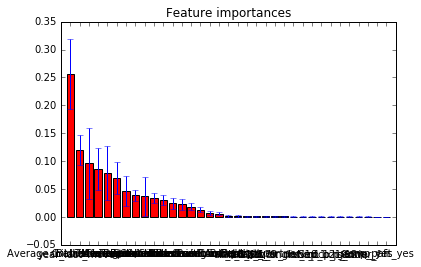

In [23]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, list(x_train.columns)[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), list(x_train.columns))
plt.xlim([-1, x_train.shape[1]])
plt.show()

## Partial Dependence Plot

One big difference that we find in these algorithms is that we dont have straight forward coefficients associated with variables. We dont have a clear picture of how a particular variable affects our response, other than saying that some variable is importent and some are not.

We can solve that issue by building partial dependence plots ourselves. Sklearn currently has partial dependence plot support only for gradient boosting machines. fret not , we can atleast implement a basic version of dependence plot ourselves.

Idea is to fix all other variables and vary particular predictor in question and see how the predicted response values move. [A better implementation will be where we randomly sample other variables instead of fixing them to a fixed value but that will take a lot of time and code, lets keep it simple for now]



In [56]:
# We'll  do this for variable Average Credit Card Transaction
# You can try to generalise the process and even write a function if you want

data=x_train.copy()

features=x_train.columns

for f in features:
    if f=='Average Credit Card Transaction':pass
    else:
        data[f]=data[f].mean()

data=data.drop_duplicates()
data['response']=pd.Series(list(zip(*rf.predict_proba(x_train)))[1])


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.6s finished


//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python3.5/site-packages/ggplot/stats/stat_smooth.py:22: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(['x'])


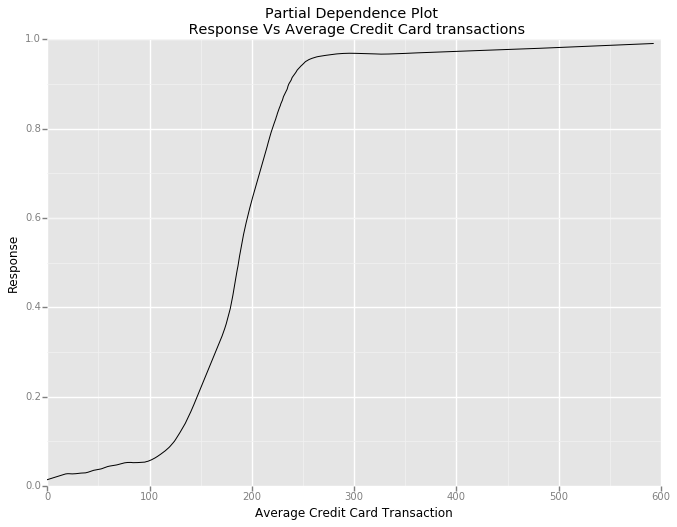

<ggplot: (293927716)>

In [66]:
from ggplot import *
ggplot(data,aes(x='Average Credit Card Transaction',y='response'))+\
geom_smooth(se=False,span=0.2)+xlab("Average Credit Card Transaction")+\
ylab('Response')+\
ggtitle('Partial Dependence Plot \n Response Vs Average Credit Card transactions')

Note : You might have realised that you can extend this idea to any algorithm which doesnt give explicit coefficient by design. Another thing that you can do by using these partial dependence plot for exotic algorithms is that you can generate features with novel transformation and keep the major training algorithm simple to understand and interpret.

### Interpretation and caution

Just as a simple coefficient will tell you by its magnitude how much it can affect response; by looking at this plot you can decipher that uptil around ACCB value =125, chances remain in favor of outcome 0, and then linearly grow [Quite Steeply ] ,uptil around 250 and then onwards they are almost certain on outcome as 1. In general higher ACCB leads to outcome 1.

A word of caution here will be that , we assumed every other variable to be constant as we varied ACCB here , which will not be real scenario. Even if we ignored interaction with other variables , we should atleast look at variance in the partial trend that we observe. This can be assessed by sampling other variables for each unique value of predictor in question. This will be a time taking process, but definitely will give more reliable results.

We'll conclude our discussion here. Please do the Practice Exercises . If you face any issue we'll discuss that either in class or QA forum on LMS. 

Prepared By : Lalit Sachan (lalit.sachan@edvancer.in) 

In case of any doubts or errata alert; please take to QA forum for discussion. Doubts will be discussed in live class sessions too. [This doesnt apply for self paced students]